In [1]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [2]:
starry.__version__

'1.0.0.dev3'

In [3]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [4]:
time, vels, verr = np.loadtxt('../data/transit.vels', usecols=[0,1,2], unpack=True)
time -= 2458706.5

In [5]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.168
e = 0.0                   
w = 0.0
inc = 90.0


vsini = 18.3 * 1e3      # m /s
r = 0.06472             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = -0
gamma = -15
gammadot = 100
gammadotdot = 800

veq = vsini / np.sin(inc * np.pi / 180.0)



Compiling `rv`... Done.


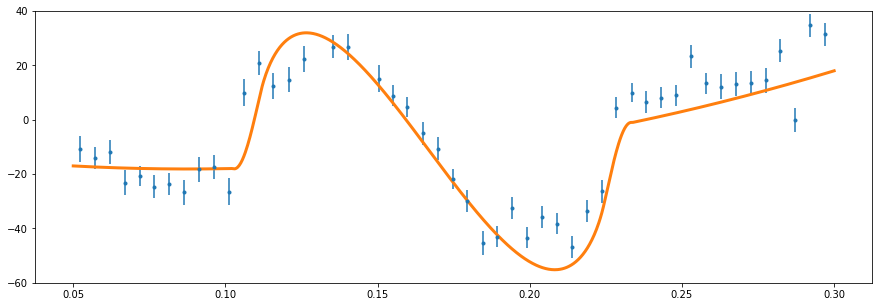

In [6]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)


f = (t - t0)/P*2*np.pi
I = np.arccos(b/a)

zo = a*np.cos(f) 
yo = -a*np.sin(np.pi/2+f)*np.cos(I)
xo = a*np.sin(f)*np.sin(I)


theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2
    

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-60, 40);

In [9]:
#map.show(rv=False)

In [10]:
from scipy.optimize import minimize

In [59]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0


def rmcurve(params):
    
    vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, factor, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    if u1 + u2 > 1.0:
        print('inf')
        return 2700

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (tuse - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tuse

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    trend = gamma + gammadot*(tuse-0.15) + gammadotdot*(tuse-0.15)**2
    rv = rv_0 + trend
    
    
    var_good = (euse**2 + jitter_good**2)
    var_bad  = (euse**2 + jitter_bad**2)
   
    goodgauss = q / np.sqrt(2*np.pi*var_good) * np.exp(-(rv-vuse)**2/(2*var_good))
    badgauss  = (1-q) / np.sqrt(2*np.pi*var_bad) * np.exp(-(rv_0*factor+trend-vuse)**2/(2*var_bad))

    totgauss = np.log(goodgauss + badgauss)
    
    #print(np.log(goodgauss))
    #print(np.log(badgauss))
        
    print(-1*np.sum(totgauss))
    return -1*np.sum(totgauss)



In [60]:
def plot_rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, factor, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (t - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)

    theta = 360.0 / Prot * t

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2

    plt.figure(figsize=(15,5))
    plt.plot(t, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-50, 40);
    plt.show()


190.7659992701508


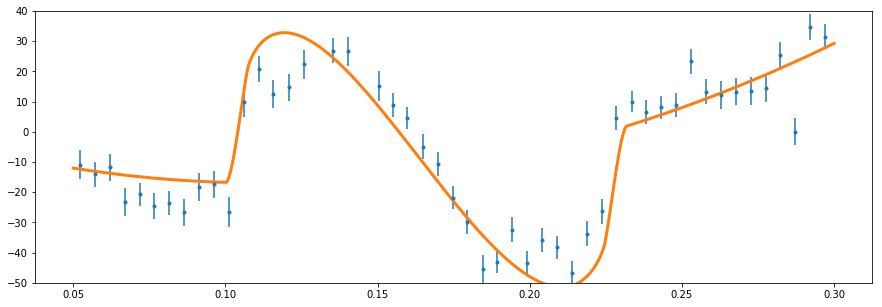

In [72]:
inputs = np.array([19300, 0.0588, -0.09, 20.79, 0.8, 0.00, 10.0, -15.0, 100.1, 1300.0, 1.0, 1.0, 0.8, 0.60, 0.166])

bnds = ((12000, 24000), (0.04, 0.07), (-1.0, 0.0), (15,25), (0,1),(0,1), (-30,90), (-20,20),(50,300), (100, 1500), (0.0, 2.0), (0.0, 20.0), (0.4, 1.0), (0.0, 1.0), (0.16, 0.175))
rmcurve(inputs)

plot_rmcurve(inputs)

In [73]:
res = minimize(rmcurve, inputs, method='L-BFGS-B', bounds=bnds)

190.7659992701508
190.76599927014186
190.76599411900986
190.7659997117711
190.76599910298438
190.76599885867563
190.76599899170662
190.76599926913738
190.7659992728386
190.76599926701223
190.76599927018668
190.76599924164242
190.76599926168706
190.7659995136279
190.76599881384917
190.76598116074285
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
188.4147372187533
188.41473721874405
188.41473188410032
188.41473760922045
188.41473708326853
188.41473685950382
188.41473698344936
188.41473721777496
188.41473722205262
188.41473721567502
188.4147372187868
188.41473719142988
188.41473721098035
188.4147374472033
188.4147367802099
188.4147300050881
179.77119668183465
179.7711966818316
179.77119440740853
179.7711963338303
179.771196789527
179.7711967865288
179.7711968283221
179.7711966788956
179.77119668290715
179.77119667916045
179.77119668186765
179.77119665711436
179.77119667658033
179.77119676705928
179.7711965345463
179.77119423738225
356.92583001859975
356.9258300187202
356.

176.08968726117823
176.08968724961738
176.08968725262065
176.08968723750107
176.08968724171245
176.08968722165244
176.08968715081156
176.0896882985694
175.86057052281305
175.8605705228151
175.8605722891228
175.86057054558879
175.86057053237084
175.8605704901452
175.86057054936325
175.86057052111497
175.8605705304791
175.86057051983062
175.86057052284684
175.86057050792238
175.86057051173907
175.86057049059252
175.86057049638057
175.86057188699024
175.8207594829658
175.8207594829635
175.82075853064399
175.82075945623217
175.82075949444604
175.820759446447
175.82075950658108
175.82075948147545
175.8207594904303
175.82075948005328
175.82075948300186
175.82075946815175
175.82075947181062
175.82075943917923
175.82075944852247
175.82076066320386
175.81124725010048
175.81124725009946
175.81124713728585
175.81124725532212
175.81124725864115
175.81124720942557
175.81124727105689
175.81124724843275
175.81124725735688
175.81124724715133
175.81124725013566
175.81124723528083
175.8112472388931
175.

175.4120172453218
175.3986227150424
175.39862271504353
175.39862410579647
175.39862282210726
175.3986227040858
175.3986226431237
175.39862270739502
175.39862271360803
175.39862272324436
175.39862271200394
175.3986227150738
175.39862269908926
175.39862270530287
175.39862270364324
175.39862276076136
175.39862263879013
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
175.39862266558745
175.39862266558856
175.39862405633914
175.39862277265235
175.39862265463086
175.39862259366873
175.39862265794005
175.39862266415307
175.39862267378942
175.398622662549
175.39862266561886
175.3986226496343
175.39862265584793
175.3986226541883
175.3986227113064
175.39862258933636
175.38822263159688
175.38822263159696
175.38822333206272
175.3882227227852
175.38822262145882
175.38822255968793
175.38822262366293
175.38822263023093
175.3882226397696
175.38822262857983
175.3882226316288
175.38822261559852
175.38822262191198
175.3882226178115
175.38822266747619
175.3882228568581
inf
inf
inf
inf
inf


175.33235259358972
175.31269798110287
175.31269798110225
175.31269819992707
175.3126980146257
175.31269798282688
175.3126979369348
175.31269799581048
175.3126979794961
175.3126979884916
175.31269797812087
175.3126979811346
175.31269796398183
175.31269797266194
175.3126979836614
175.3126979985484
175.31269780430472
175.28935526374744
175.28935526374696
175.28935560284717
175.28935527412668
175.28935526721207
inf
inf
175.2893552624133
175.28935527209083
175.2893552607837
175.28935526378007
175.28935524613857
175.2893552558569
175.2893552751685
175.289355283885
175.28935499699347
175.31269756888037
175.31269756887974
175.31269778770627
175.31269760240284
175.31269757060434
175.3126975247123
175.31269758358798
175.31269756727363
175.31269757626907
175.3126975658984
175.31269756891206
175.3126975517593
175.31269756043943
175.31269757143895
175.31269758632592
175.31269739208096
175.29709928137774
175.29709928137723
175.29709957017343
175.2970993040871
175.2970992838861
inf
inf
175.2970992799

175.23703475301153
175.23703473498145
175.23703474548935
175.23703476072743
175.2370347236182
175.23703276583768
175.23703474513414
175.23703474513226
175.23703419886883
175.23703476789734
175.23703474217083
inf
inf
175.2370347439913
175.2370347532794
175.2370347421641
175.23703474515975
175.23703472712964
175.23703473763754
175.23703475287562
175.23703471576638
175.23703275798286
175.23703474347488
175.23703474347298
175.23703419720985
175.23703476623803
175.2370347405114
inf
inf
175.23703474233199
175.23703475162012
175.23703474050478
175.23703474350043
175.23703472547035
175.23703473597823
175.23703475121633
175.23703471410707
175.23703275632303
175.23703474312424
175.2370347431223
175.23703419685918
175.23703476588747
175.23703474016088
inf
inf
175.23703474198135
175.23703475126945
175.23703474015417
175.2370347431498
175.23703472511968
175.23703473562762
175.2370347508657
175.23703471375646
175.23703275597217
175.23703474305006
175.23703474304816
175.23703419678512
175.23703476581

In [74]:
# vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, factor, t0
print(res.x.tolist())

[19299.999257861025, 0.06078305799279333, -0.26842308404132836, 20.45127084401793, 0.9999999998010554, 0.0, 10.048742594672486, -15.075031151578681, 100.04159613003901, 1300.0007435582133, 1.0844716946805428, 1.0055472803019998, 0.6647339097213981, 0.6908688052159306, 0.16522744788036733]


175.2370347430302


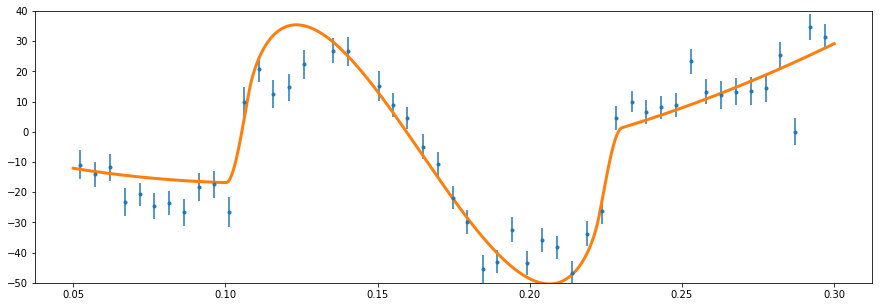

In [75]:
test = res.x + 0.0
#test[0] = 20000
#test[4] = 1.0
#test[5] = 0.0
rmcurve(test)
plot_rmcurve(test)

In [81]:
orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=0.4, ecc=e, omega=w, r_star=1.0) 

x, y, z = orbit.get_relative_position(tuse)


In [82]:
xp = x.eval()
yp = y.eval()
zp = z.eval()

In [83]:
(zp**2+yp**2+xp**2)**0.5

array([19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42])

In [84]:
a

19.42

In [85]:
tuse = np.arange(-4, 4, 0.1)

f = (tuse - t0)/P*2*np.pi
I = np.arccos(b/a)


In [106]:


zpos = a*np.cos(f) 
ypos = -a*np.sin(np.pi/2+f)*np.cos(I)
xpos = a*np.sin(f)*np.sin(I)

In [108]:
zpos-zp

array([-4.10861147e-03, -4.11988110e-03, -4.10660824e-03, -4.06887196e-03,
       -4.00689705e-03, -3.92105270e-03, -3.81185031e-03, -3.67994039e-03,
       -3.52610875e-03, -3.35127177e-03, -3.15647097e-03, -2.94286680e-03,
       -2.71173171e-03, -2.46444261e-03, -2.20247260e-03, -1.92738228e-03,
       -1.64081037e-03, -1.34446401e-03, -1.04010856e-03, -7.29557091e-04,
       -4.14659590e-04, -9.72919255e-05,  2.20655316e-04,  5.37288094e-04,
        8.50720200e-04,  1.15908449e-03,  1.46054402e-03,  1.75330295e-03,
        2.03561731e-03,  2.30580532e-03,  2.56225745e-03,  2.80344598e-03,
        3.02793415e-03,  3.23438464e-03,  3.42156763e-03,  3.58836804e-03,
        3.73379223e-03,  3.85697389e-03,  3.95717923e-03,  4.03381130e-03,
        4.08641361e-03,  4.11467280e-03,  4.11842052e-03,  4.09763446e-03,
        4.05243843e-03,  3.98310167e-03,  3.89003722e-03,  3.77379949e-03,
        3.63508091e-03,  3.47470783e-03,  3.29363561e-03,  3.09294292e-03,
        2.87382531e-03,  

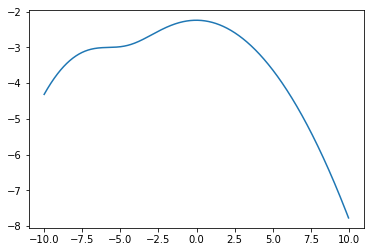

In [50]:
x = np.arange(-10, 10, 0.02)
sigma1 = 3
mu1 = 0

sigma2 = 2
mu2 = -7
g1 = 0.8/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 = 0.2/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

plt.plot(x, np.log(g1+g2))
#plt.plot(x, g1)
#plt.plot(x, g2)


In [ ]:
var_good = (euse**2 + jitter_good**2)
var_bad  = (euse**2 + jitter_bad**2)
gooddata = -0.5*q*(np.sum((rv-vuse)**2/var_good + np.log(2*np.pi*var_good)))
baddata  = -0.5*(1-q)*(np.sum((rv-vuse)**2/var_bad + np.log(2*np.pi*var_bad)))
lnprob = gooddata + baddata
    
goodgauss = q / np.sqrt(2*np.pi*var_good) * np.exp(-(rv-vuse)**2/var_good)
badgauss  = (1-q) / np.sqrt(2*np.pi*var_bad) * np.exp(-(rv-vuse)**2/var_bad)

totgauss = np.log(goodgauss + badgauss)

